<a href="https://colab.research.google.com/github/Iamsdt/UdacityPyTorch/blob/master/src/notebook/final/desnet201Flower6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

#!pip install torchsummary

import torch

tcmalloc: large alloc 1073750016 bytes == 0x58a44000 @  0x7f75e69012a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
# Load train class
!wget -c https://raw.githubusercontent.com/Iamsdt/UdacityPyTorch/master/src/notebook/Train.py

import Train

--2019-01-01 05:21:10--  https://raw.githubusercontent.com/Iamsdt/UdacityPyTorch/master/src/notebook/Train.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15527 (15K) [text/plain]
Saving to: ‘Train.py’

Train.py            100%[===================>]  15.16K  --.-KB/s    in 0.007s  

2019-01-01 05:21:10 (2.23 MB/s) - ‘Train.py’ saved [15527/15527]



In [0]:
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch import optim
from collections import OrderedDict
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import os
import json
from PIL import Image
import Train

# Load a Pretrained Model

In [0]:
# load a pretrained model
model = models.densenet201(pretrained = True)
num_ftrs = model.classifier.in_features
num_ftrs

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


1920

# Load previous model

In [0]:
# laod model
model_save_name = 'desnet201_94unfreeze_4pm_1_19.pt'
path = F"/content/gdrive/My Drive/model/final/{model_save_name}"
model.load_state_dict(torch.load(path))
# model, optimizer, scheduler = Train.load_checkpoint(path, model, lr=0.01)

# Build

In [0]:
# if model is not save then run this cell
# change classifier
fc = nn.Sequential(OrderedDict([
                ('fc1', nn.Linear(1920, 1780)),
                #('fc2', nn.Linear(1780, 1780)),
                ('fc2', nn.Linear(1780, 1500)),
                ('fc3', nn.Linear(1500, 1024)),
                #('fc5', nn.Linear(1024, 1024)),
                ('fc4', nn.Linear(1024, 786)),
                ('fc5', nn.Linear(786, 500)),
                ('relu', nn.ReLU()),
                ("dropout",nn.Dropout(p=0.20)),
                ('fc6', nn.Linear(500, 102)),
                ('output', nn.LogSoftmax(dim=1))
                ]))
model.classifier = fc
model.classifier

Sequential(
  (fc1): Linear(in_features=1920, out_features=1780, bias=True)
  (fc2): Linear(in_features=1780, out_features=1500, bias=True)
  (fc3): Linear(in_features=1500, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=786, bias=True)
  (fc5): Linear(in_features=786, out_features=500, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2)
  (fc6): Linear(in_features=500, out_features=102, bias=True)
  (output): LogSoftmax()
)

# Prepare Data

In [0]:
# Load data
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json

!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip

!unzip -qq flower_data.zip

print("Data loaded")

Data loaded


In [0]:
import Train

# create train and test loader
data_dir = 'flower_data'

from torchvision import datasets, transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_valid = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# ceate data loader
train_loader, valid_loader, test_loader = Train.prepare_loader(data_dir,transform_train,transform_valid,test_transforms)

Train size:6552
Valid size:6552
Test size:818


# Train Model

In [0]:
# Freeze the parameter
model = Train.freeze_parameters(model)
#for _, param in model.named_parameters():
#  param.requires_grad = False
print("Parameter Freezed")

Parameter Freezed


In [0]:
# Unfreeze the parameter
model = Train.unfreeze(model)
#for _, param in model.named_parameters():
#  param.requires_grad = True

print("Parameter unfreezed")

Parameter unfreezed


In [0]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl


In [0]:
# 7freeze + 
total_epochs_count = 7+7+7+7+7

In [0]:
# unfreeze the last layer
for pram in model.classifier.parameters():
   pram.requires_grad = True
    
print("Last layer Unfreeze")

Last layer Unfreeze


In [0]:
# if model is not save then run this cell
# set cretrion and optimizer
criterion = nn.NLLLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

#optimizer = optim.Adadelta(model.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#move tensor to default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [0]:
optimizer.state_dict

<bound method Optimizer.state_dict of SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.003
    lr: 0.003
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)>

In [0]:
# Train model
epochs = 5
model, train_loss,valid_loss = Train.train_model(
    model,train_loader,valid_loader, epochs, optimizer,scheduler, criterion)

Epoch: 1/5
		Going for validation
	Train loss:0.314600.. 	Valid Loss:0.031466.. 	Accuracy: 95.1908
	Validation loss decreased (inf --> 0.031466).  Saving model ...
	Epoch:1 completed in 3m 28s
Epoch: 2/5
		Going for validation
	Train loss:0.297894.. 	Valid Loss:0.027156.. 	Accuracy: 96.6412
	Validation loss decreased (0.031466 --> 0.027156).  Saving model ...
	Epoch:2 completed in 3m 27s
Epoch: 3/5
		Going for validation
	Train loss:0.327502.. 	Valid Loss:0.032692.. 	Accuracy: 95.8015
	Epoch:3 completed in 3m 27s
Epoch: 4/5
		Going for validation
	Train loss:0.281945.. 	Valid Loss:0.021495.. 	Accuracy: 97.0229
	Validation loss decreased (0.027156 --> 0.021495).  Saving model ...
	Epoch:4 completed in 3m 27s
Epoch: 5/5
		Going for validation
	Train loss:0.237159.. 	Valid Loss:0.023621.. 	Accuracy: 96.5649
	Epoch:5 completed in 3m 27s
Training completed in 17m 16s


In [0]:
mean = [0.4305, 0.3757, 0.2835]
std = [0.2942, 0.2424, 0.2675]

# Load model

In [0]:
# Load best model
name = "model.pt"
model.load_state_dict(torch.load(name))

In [0]:
#save model for further use
torch.save(model.state_dict(),"model64unfreeze.pt")

# Testing

In [0]:
train_data, valid_data = [],[]

In [0]:
#save test_data
for i in train_loss:
  train_data.append(i)
  
# valid
for i in valid_loss:
  valid_data.append(i)

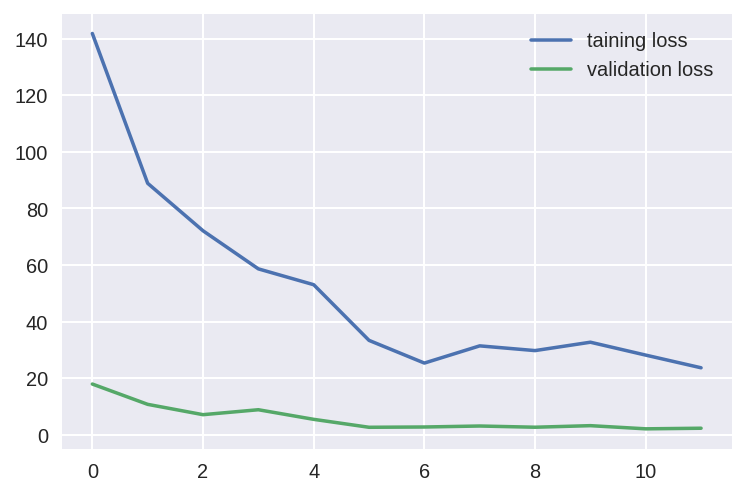

In [0]:
#Check for overfitting
plt.plot(train_data, label = "taining loss")
plt.plot(valid_data, label = "validation loss")
plt.legend(frameon = False)

In [0]:
#criterion = nn.CrossEntropyLoss()
# Test accuracy top 10 classs
Train.calculate_top_accuracy(model, test_loader, criterion,size=10)

Test Loss: 0.007976

Test Accuracy of     0: 100% ( 2/ 2)
Test Accuracy of     1: 100% ( 2/ 2)
Test Accuracy of     2: 100% ( 4/ 4)
Test Accuracy of     3: 100% ( 4/ 4)
Test Accuracy of     4: 100% ( 5/ 5)
Test Accuracy of     5: 100% ( 5/ 5)
Test Accuracy of     6: 100% ( 2/ 2)
Test Accuracy of     7: 100% ( 2/ 2)
Test Accuracy of     8: N/A (no training examples)
Test Accuracy of     9: 100% ( 4/ 4)

Test Accuracy (Overall): 96% (395/410)


In [0]:
# Test total accuracy
Train.calc_accuracy(model,testset_path="flower_data/valid",batch_size=batch_size)

Batch accuracy (Size 20): 1.0
Batch accuracy (Size 20): 0.949999988079071
Batch accuracy (Size 20): 1.0
Batch accuracy (Size 20): 1.0
Batch accuracy (Size 20): 1.0
Batch accuracy (Size 20): 1.0
Batch accuracy (Size 20): 0.949999988079071
Batch accuracy (Size 20): 1.0
Batch accuracy (Size 20): 0.949999988079071
Batch accuracy (Size 20): 0.949999988079071
Batch accuracy (Size 20): 0.949999988079071
Batch accuracy (Size 20): 0.949999988079071
Batch accuracy (Size 20): 0.949999988079071
Batch accuracy (Size 20): 1.0
Batch accuracy (Size 20): 0.949999988079071
Batch accuracy (Size 20): 1.0
Batch accuracy (Size 20): 0.8500000238418579
Batch accuracy (Size 20): 1.0
Batch accuracy (Size 20): 0.9000000357627869
Batch accuracy (Size 20): 0.949999988079071
Batch accuracy (Size 20): 0.949999988079071
Batch accuracy (Size 20): 0.9000000357627869
Batch accuracy (Size 20): 0.949999988079071
Batch accuracy (Size 20): 1.0
Batch accuracy (Size 20): 0.9000000357627869
Batch accuracy (Size 20): 1.0
Batch 

0.9644986

In [0]:
# Test with google data set
Train.calc_accuracy(model,use_google_testset=True,batch_size=batch_size)

# Save checkpoint

In [0]:
#save model
name = "model1_19_97.pt"
Train.save_check_point(model, optimizer, scheduler, train_loader, name, 7, save_cpu=False)

Model saved at model1_19_97.pt


In [0]:
#load model again
model, optimizer, scheduler = Train.load_checkpoint(name, model)

26,971,084 total parameters.
8,878,156 total gradient parameters.
Model has been trained for 7 epochs.


# Image Preprocessing

In [0]:
#Time for visalize
cat_to_name = Train.get_cat_name()
class_to_idx = train_loader.dataset.class_to_idx
idx_to_name = {idx: cat_to_name[category] for category, idx in train_loader.dataset.class_to_idx.items()}
list(idx_to_name.items())[:6]
list(cat_to_name.keys())[:6]

['21', '3', '45', '1', '34', '27']

In [0]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a PyTorch tensor
    '''
    
    image = Image.open(image_path)
    
    # Resize
    img = image.resize((256, 256))
    
    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    img = img.crop((left, top, right, bottom))
    
    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256
    
    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)
    
    return img_tensor

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image); plt.axis('off')
    
    return ax, image

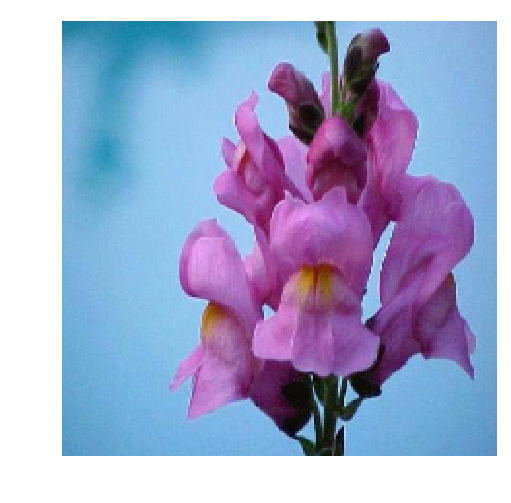

In [0]:
img = process_image('flower_data/valid/11/image_03125.jpg')
ax, image = imshow(img)

# Class Prediction

In [0]:
def random_image_path():
    """Generate a random image path from validation set"""
    cat = np.random.choice(os.listdir(f'flower_data/valid/'))
    image_filename = np.random.choice(os.listdir(f'flower_data/valid/{cat}/'))
    ex_path = f'flower_data/valid/{cat}/' + image_filename
    print(f"Path:{ex_path}")
    return ex_path

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    real_class = model.cat_to_name[image_path.split('/')[2]]
    img_tensor = process_image(image_path)
    
    if torch.cuda.is_available():
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Output is not a probability or a log probability
        out = model(img_tensor)
        
        # Apply softmax across classes
        ps = torch.softmax(out, dim = 1)
        
        topk, topclass = ps.topk(topk, dim = 1)
        top_classes = [model.idx_to_name[class_] for class_ in topclass.cpu().numpy()[0]]
        top_ps = topk.cpu().numpy()[0]
        return top_ps, top_classes, real_class, img_tensor.cpu().squeeze()

In [0]:
ex_path = random_image_path()
ps, classes, y_obs, img = predict(ex_path, model)

Path:flower_data/valid/93/image_07303.jpg


(array([9.8991418e-01, 8.9760935e-03, 1.0309143e-03, 3.2019903e-05,
        6.4684532e-06], dtype=float32),
 ['foxglove',
  'toad lily',
  'fritillary',
  'hard-leaved pocket orchid',
  'tiger lily'])

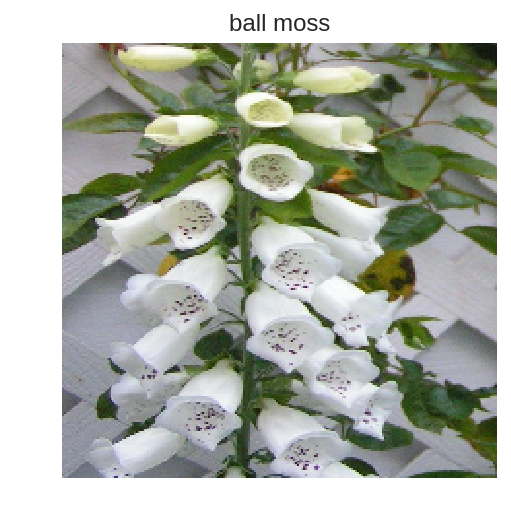

In [0]:
ax, img = imshow(img);
ax.set_title(y_obs);
ps, classes

# Sanity Checking



In [0]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""
    # Get predictions
    real_cat = image_path.split('/')[2]
    n_train_images = len(os.listdir(f'flower_data/train/{real_cat}'))
    
    ps, classes, y_obs, img = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index = classes)
    
    plt.figure(figsize = (6, 5))
    ax = plt.subplot(1, 1, 1)
    ax, img = imshow(img, ax = ax);
    ax.set_title(y_obs, size = 20);
    plt.show();
    
    result.sort_values('p')['p'].plot.barh(color = 'blue', edgecolor = 'k');
    plt.xlabel('Predicted Probability'); plt.ylabel('Classes');
    plt.show();
    
    print(f'{n_train_images} training images for {y_obs}.')

Path:flower_data/valid/70/image_05284.jpg


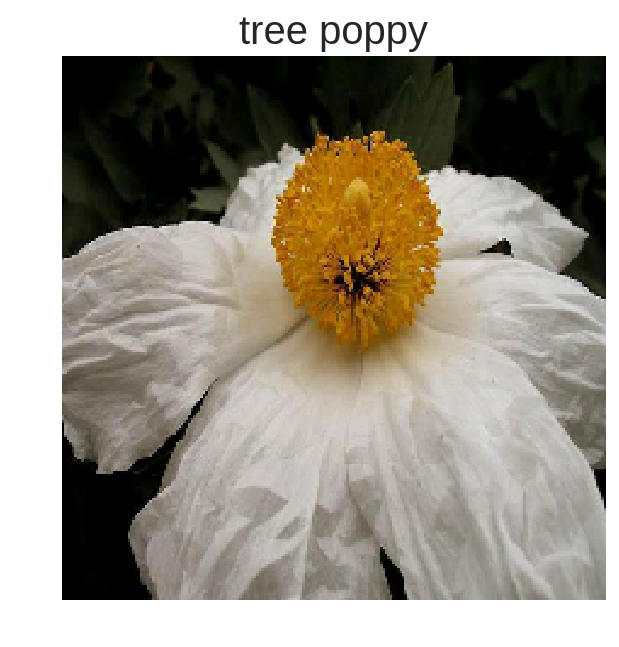

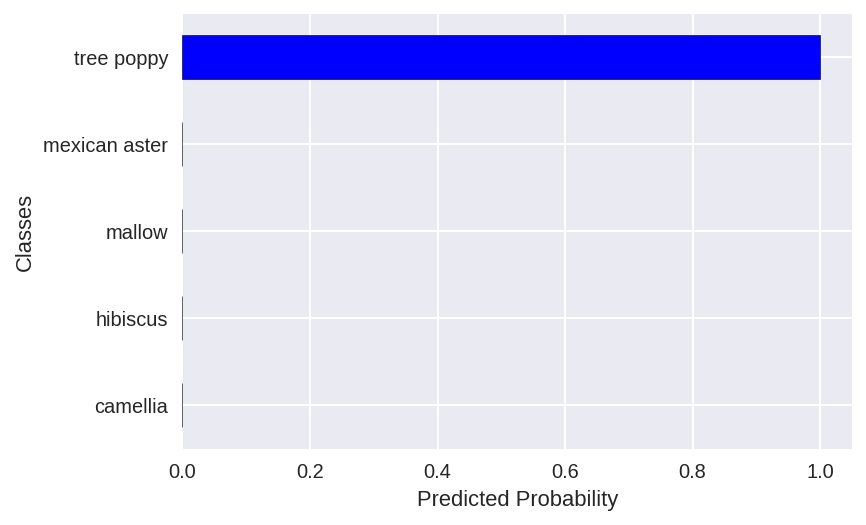

51 training images for tree poppy.


In [0]:
import pandas as pd
ex_path = random_image_path()
display_prediction(ex_path, model, 5)

# Save on Google Drive
Save to the google drive for latter use

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
model_save_name = 'desnet201_97freeze_5pm_1_19.pt'
path = F"/content/gdrive/My Drive/model/final/{model_save_name}" 
torch.save(model.state_dict(), path)

In [0]:
#Save checkpoint
model_save_name = 'final_28_1a_71.pt'
path = F"/content/gdrive/My Drive/model/final/{model_save_name}"
Train.save_check_point(model, optimizer, scheduler, train_loader, path, 7, save_cpu=False)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Model saved at /content/gdrive/My Drive/model/final_28_1a_71.pt


# Load to udacity workspace

In [0]:
my_file_id = "1HPuJ4U2rjz95UdZ2N8496jTiZQ5O3pg1"
!gdown https://drive.google.com/uc?id={my_file_id}